<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling/blob/main/insPLAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detection of damaged power infastructure using Neural Networks and Multihead Classification  

Jason Buchanan

Lakshmi Varaha Krishna Chittella

Uses the Insplad Dataset and builds a two head model for object detection of damaged power infastructure

Detection of degraded electrical tower components

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from typing import Tuple
from torchsummary import summary
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import json

In [131]:
# Define the path to the dataset
from google.colab import drive
import os
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/insplad'
base_path = f'{root_path}/defect_supervised'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loader class. Traverse the directory structure of the dataset and set it as classes for two stage classification

In [132]:
class InsPLADDataset(Dataset):
    def __init__(self, root_dir: str, split: str = 'train', transform=None):
        """
        Args:
            root_dir (str): Root directory containing class folders
            split (str): 'train' or 'val'
            transform: transform to be applied to images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # Get all main classes (top level directories)
        self.main_classes = [d for d in os.listdir(root_dir)
                           if os.path.isdir(os.path.join(root_dir, d))]

        # Initialize structures to track both main classes and subclasses
        self.main_class_to_idx = {cls: idx for idx, cls in enumerate(self.main_classes)}
        self.subclasses = {}  # Dictionary to store subclasses for each main class

        self.hierarchical_subclass_to_idx = {}  # Maps (main_class, subclass) pairs to unique indices
        self.idx_to_hierarchical_subclass = {}  # Reverse mapping for easy lookup

        self.samples = []  # Will store paths and both levels of classes

        global_subclass_idx = 0

        # Walk through the directory structure
        for main_class in self.main_classes:
            main_class_dir = os.path.join(root_dir, main_class)
            split_dir = os.path.join(main_class_dir, split)

            # Get subclasses for this main class
            self.subclasses[main_class] = []

            for subclass in os.listdir(split_dir):
                subclass_dir = os.path.join(split_dir, subclass)
                if os.path.isdir(subclass_dir):
                    # Create hierarchical key
                    hierarchical_key = (main_class, subclass)

                    # Add subclass to tracking structures
                    self.subclasses[main_class].append(subclass)

                    # Map the hierarchical pair to a unique index
                    if hierarchical_key not in self.hierarchical_subclass_to_idx:
                        self.hierarchical_subclass_to_idx[hierarchical_key] = global_subclass_idx
                        self.idx_to_hierarchical_subclass[global_subclass_idx] = hierarchical_key
                        global_subclass_idx += 1

                    # Get all images in the subclass directory
                    for img_name in os.listdir(subclass_dir):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(subclass_dir, img_name)
                            self.samples.append({
                                'path': img_path,
                                'main_class': main_class,
                                'subclass': subclass,
                                'main_class_idx': self.main_class_to_idx[main_class],
                                'hierarchical_idx': self.hierarchical_subclass_to_idx[hierarchical_key]
                            })

    def get_class_distributions(self):
        """Calculate detailed distribution of samples across classes and subclasses."""
        main_class_dist = {}
        hierarchical_subclass_dist = {}
        hierarchical_dist = {}

        for sample in self.samples:
            main_class = sample['main_class']
            subclass = sample['subclass']
            hierarchical_key = (main_class, subclass)

            # Update main class counts
            main_class_dist[main_class] = main_class_dist.get(main_class, 0) + 1

            # Update hierarchical subclass counts
            hierarchical_subclass_dist[hierarchical_key] = hierarchical_subclass_dist.get(hierarchical_key, 0) + 1

            # Update hierarchical counts
            if main_class not in hierarchical_dist:
                hierarchical_dist[main_class] = {}
            hierarchical_dist[main_class][subclass] = hierarchical_dist[main_class].get(subclass, 0) + 1

        return {
            'main_classes': main_class_dist,
            'hierarchical_subclasses': hierarchical_subclass_dist,
            'hierarchical': hierarchical_dist
        }
    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int]:
        """
        Returns:
            tuple: (image, main_class_target, hierarchical_subclass_target)
        """
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, sample['main_class_idx'], sample['hierarchical_idx']
    def get_class_info(self):
        """Returns detailed information about the dataset structure with counts."""
        info = {
            'num_main_classes': len(self.main_classes),
            'num_total_subclasses': len(self.hierarchical_subclass_to_idx),
            'main_classes': self.main_classes,
            'subclasses_per_main': self.subclasses,
            'hierarchical_mapping': self.hierarchical_subclass_to_idx,
            'class_distributions': self.get_class_distributions()
        }
        return info

Exploration class for the data once loaded

In [133]:
from prettytable import PrettyTable
def print_dataset_statistics(data_dir: str, split: str = 'train'):
    """Print detailed dataset statistics using PrettyTable."""
    dataset = InsPLADDataset(data_dir, split)
    info = dataset.get_class_info()
    distributions = info['class_distributions']

    # Create summary table
    summary_table = PrettyTable()
    summary_table.title = f"Dataset Summary ({split})"
    summary_table.field_names = ["Metric", "Value"]
    summary_table.align["Metric"] = "l"  # Left align text
    summary_table.align["Value"] = "r"   # Right align numbers

    total_images = sum(distributions['main_classes'].values())
    summary_table.add_rows([
        ["Total Images", total_images],
        ["Main Classes", info['num_main_classes']],
        ["Total Subclasses", info['num_total_subclasses']]
    ])
    print(summary_table)

    # Create detailed distribution table
    dist_table = PrettyTable()
    dist_table.title = "Class Distribution"
    dist_table.field_names = ["Main Class", "Subclass", "Images", "% of Class", "% of Total"]
    dist_table.align = "l"  # Left align all columns
    dist_table.align["Images"] = "r"     # Right align numbers
    dist_table.align["% of Class"] = "r"
    dist_table.align["% of Total"] = "r"

    for main_class in info['main_classes']:
        main_class_count = distributions['main_classes'][main_class]
        subclasses = info['subclasses_per_main'][main_class]

        # Add a row for each subclass
        for subclass in subclasses:
            subclass_count = distributions['hierarchical'][main_class][subclass]
            class_percentage = (subclass_count / main_class_count) * 100
            total_percentage = (subclass_count / total_images) * 100

            dist_table.add_row([
                main_class if subclass == subclasses[0] else "",  # Only show main class once
                subclass,
                subclass_count,
                f"{class_percentage:.1f}%",
                f"{total_percentage:.1f}%"
            ])

        # Add a separator between main classes
        if main_class != info['main_classes'][-1]:
            dist_table.add_row(["-" * len(main_class), "-" * 10, "-" * 6, "-" * 8, "-" * 8])

    print("\n" + str(dist_table))

In [134]:
def explore_dataset(data_dir):
    # Create dataset instance
    dataset = InsPLADDataset(data_dir, 'train')

    # Get and print dataset information
    info = dataset.get_class_info()

    print(f"Dataset Structure:")
    print(f"Number of main classes: {info['num_main_classes']}")
    print(f"Total number of subclasses: {info['num_total_subclasses']}")
    print("\nMain classes and their subclasses:")
    for main_class, subclasses in info['subclasses_per_main'].items():
        print(f"\n{main_class}:")
        for subclass in subclasses:
            count = info['class_distributions']['subclasses'].get(subclass, 0)
            print(f"  - {subclass}: {count} images")

    # Visualize class distributions
    plt.figure(figsize=(15, 5))

    # Main classes distribution
    plt.subplot(1, 2, 1)
    main_counts = info['class_distributions']['main_classes']
    plt.bar(main_counts.keys(), main_counts.values())
    plt.title('Main Class Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Data loader

In [135]:
def get_hierarchical_data_loaders(data_dir: str, batch_size: int = 32):
    """
    Creates data loaders with proper train/val split using the existing directory structure.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create separate datasets for train and val using the existing directory structure
    train_dataset = InsPLADDataset(data_dir, 'train', transform=transform)
    val_dataset = InsPLADDataset(data_dir, 'val', transform=transform)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    # Print dataset statistics
    print("\nDataset Statistics:")
    print("=" * 50)

    def print_split_stats(dataset, name):
        main_counts = {}
        sub_counts = {}

        for sample in dataset.samples:
            main_class = sample['main_class']
            sub_class = f"{main_class}/{sample['subclass']}"

            main_counts[main_class] = main_counts.get(main_class, 0) + 1
            sub_counts[sub_class] = sub_counts.get(sub_class, 0) + 1

        print(f"\n{name} Set:")
        print(f"Total samples: {len(dataset)}")
        print("\nMain class distribution:")
        for cls, count in main_counts.items():
            print(f"{cls}: {count}")
        print("\nSubclass distribution:")
        for cls, count in sub_counts.items():
            print(f"{cls}: {count}")

    print_split_stats(train_dataset, "Training")
    print_split_stats(val_dataset, "Validation")

    return train_loader, val_loader

Start running

Explore the dataset

helper functions

In [136]:
def explore_dataset(data_dir):
    """Explore and visualize dataset statistics."""
    # Print statistics for both splits
    for split in ['train', 'val']:
        print(f"\n{split.upper()} SET STATISTICS")
        print("=" * 80)
        print_dataset_statistics(data_dir, split)

    # Create visualization
    dataset = InsPLADDataset(data_dir, 'train')
    info = dataset.get_class_info()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Main class distribution
    main_counts = info['class_distributions']['main_classes']
    bars1 = ax1.bar(main_counts.keys(), main_counts.values())
    ax1.set_title('Distribution of Images Across Main Classes')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)


TRAIN SET STATISTICS
+--------------------------+
| Dataset Summary (train)  |
+------------------+-------+
| Metric           | Value |
+------------------+-------+
| Total Images     |  5108 |
| Main Classes     |     5 |
| Total Subclasses |    11 |
+------------------+-------+

+----------------------------------------------------------------------------------+
|                                Class Distribution                                |
+---------------------------------+-------------+--------+------------+------------+
| Main Class                      | Subclass    | Images | % of Class | % of Total |
+---------------------------------+-------------+--------+------------+------------+
| yoke-suspension                 | rust        |    290 |      49.2% |       5.7% |
|                                 | good        |    299 |      50.8% |       5.9% |
| ---------------                 | ----------  | ------ |   -------- |   -------- |
| glass-insulator                 | 

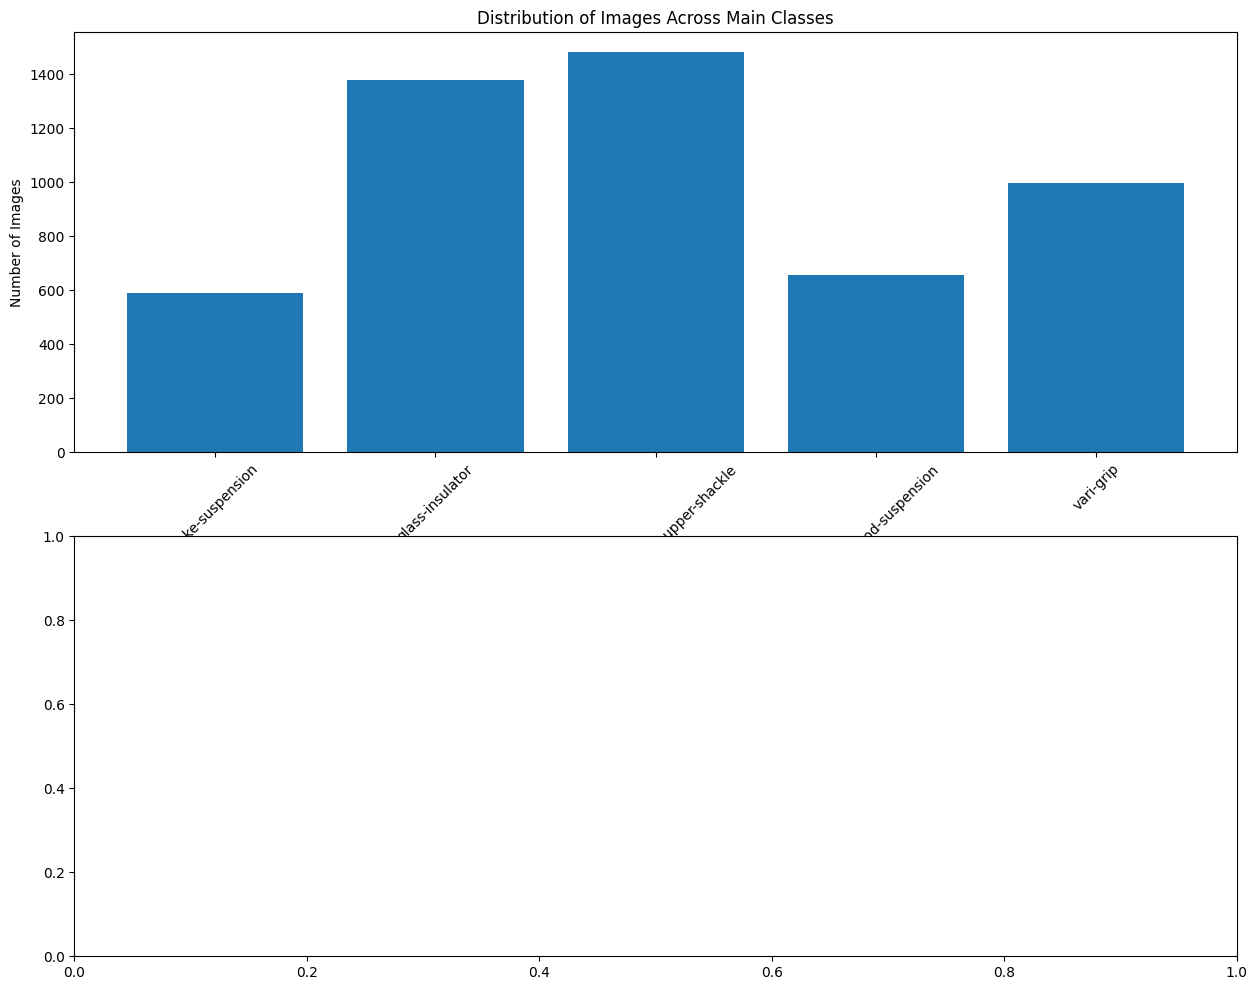

In [137]:
explore_dataset(base_path)

Save the metrics generated by two stage classifier since it's slow to run

In [138]:
def save_training_metrics(main_metrics, sub_metrics):
    save_dir = '/content/drive/MyDrive/insplad/report'
    os.makedirs(save_dir, exist_ok=True)
    # Save training metrics
    metrics = {
        'main_metrics': main_metrics,  # (train_losses, val_accuracies)
        'sub_metrics': sub_metrics     # Dict of metrics per main class
    }

    metrics_path = os.path.join(save_dir, 'training_metrics.pkl')
    with open(metrics_path, 'wb') as f:
        pickle.dump(metrics, f)

    print(f"Training metrics saved to {metrics_path}")

def load_training_metrics():
    """
    Load training metrics from Google Drive.

    Returns:
        tuple: (main_metrics, sub_metrics)
    """
    save_dir = '/content/drive/MyDrive/insplad/report'
    metrics_path = os.path.join(save_dir, 'training_metrics.pkl')
    with open(metrics_path, 'rb') as f:
        metrics = pickle.load(f)

    print(f"Training metrics loaded from {metrics_path}")
    return metrics['main_metrics'], metrics['sub_metrics']


Two stage classification

In [139]:
class TwoHeadModel(nn.Module):
    def __init__(self, feature_dim, num_main_classes, num_hierarchical_subclasses):
        super().__init__()
        # Print initialization values for debugging
        print(f"Initializing TwoHeadModel with:")
        print(f"- Feature dim: {feature_dim}")
        print(f"- Main classes: {num_main_classes}")
        print(f"- Subclasses: {num_hierarchical_subclasses}")

        self.base = resnet18(weights = ResNet18_Weights.DEFAULT)
        self.base.fc = nn.Identity()
        self.feature_dim = feature_dim
        self.main_classifier = nn.Linear(feature_dim, num_main_classes)
        self.subclass_classifier = nn.Linear(feature_dim, num_hierarchical_subclasses)

        # Initialize subclass classifier as inactive
        self.subclass_classifier.requires_grad = False

    def forward(self, tensor, mode='main'):
        features = self.base(tensor)
        if mode == 'main':
            return self.main_classifier(features)
        elif mode == 'both':
            return self.main_classifier(features), self.subclass_classifier(features)
        else:  # subclass mode
            return self.subclass_classifier(features)


In [140]:
class HierarchicalClassifier:
    def __init__(self, device: torch.device):
        self.device = device
        self.model = None
        # Initialize all mappings as None
        self.main_class_to_idx = None
        self.idx_to_main = None
        self.hierarchical_subclass_to_idx = None
        self.idx_to_hierarchical_subclass = None
        self.save_dir = '/content/drive/MyDrive/insplad/models'
        os.makedirs(self.save_dir, exist_ok=True)

    def create_model(self, train_loader):
      """Initialize model and store class mappings."""
      # Store class mappings from dataset
      self.main_class_to_idx = train_loader.dataset.main_class_to_idx
      self.hierarchical_subclass_to_idx = train_loader.dataset.hierarchical_subclass_to_idx
      self.idx_to_hierarchical_subclass = train_loader.dataset.idx_to_hierarchical_subclass

      # Create reverse mapping for main classes
      self.idx_to_main = {v: k for k, v in self.main_class_to_idx.items()}

      # Print debug information
      print("\nModel Creation Debug Info:")
      print(f"Number of main classes: {len(self.main_class_to_idx)}")
      print(f"Number of hierarchical subclasses: {len(self.hierarchical_subclass_to_idx)}")
      print("Main classes:", list(self.main_class_to_idx.keys()))
      print("Number of subclasses per main class:")
      for main_class in self.main_class_to_idx:
          subclasses = [k[1] for k in self.hierarchical_subclass_to_idx.keys() if k[0] == main_class]
          print(f"- {main_class}: {len(subclasses)} subclasses")

      # Initialize model with correct number of classes
      feature_dim = 512  # ResNet18's feature dimension
      # feature_dim = 2048  # ResNet50's feature dimension
      self.model = TwoHeadModel(
          feature_dim=feature_dim,
          num_main_classes=len(self.main_class_to_idx),
          num_hierarchical_subclasses=len(self.hierarchical_subclass_to_idx)
      )
      self.model = self.model.to(self.device)

    def save_model(self, phase='main'):
        """Save the complete model and mappings."""
        if not all([self.main_class_to_idx, self.idx_to_main,
                   self.hierarchical_subclass_to_idx, self.idx_to_hierarchical_subclass]):
            raise ValueError("Model mappings not properly initialized before saving")

        # Save model
        save_path = os.path.join(self.save_dir, f'hierarchical_{phase}_full.pth')
        torch.save(self.model, save_path)

        # Save all mappings
        mappings = {
            'main_class_to_idx': self.main_class_to_idx,
            'idx_to_main': self.idx_to_main,
            'hierarchical_subclass_to_idx': {str(k): v for k, v in self.hierarchical_subclass_to_idx.items()},
            'idx_to_hierarchical_subclass': {str(k): v for k, v in self.idx_to_hierarchical_subclass.items()}
        }
        mapping_path = os.path.join(self.save_dir, f'hierarchical_{phase}_mappings.json')
        with open(mapping_path, 'w') as f:
            json.dump(mappings, f, indent=4)

        print(f"Model and mappings saved to {self.save_dir}")

    def load_model(self, phase='main'):
        """Load the complete model and mappings."""
        load_path = os.path.join(self.save_dir, f'hierarchical_{phase}_full.pth')
        mapping_path = os.path.join(self.save_dir, f'hierarchical_{phase}_mappings.json')

        if os.path.exists(load_path) and os.path.exists(mapping_path):
            # Load model
            self.model = torch.load(load_path)
            self.model = self.model.to(self.device)

            # Load mappings
            with open(mapping_path, 'r') as f:
                mappings = json.load(f)

            # Restore all mappings
            self.main_class_to_idx = mappings['main_class_to_idx']
            self.idx_to_main = mappings['idx_to_main']

            # Convert string tuple keys back to actual tuples for hierarchical mappings
            self.hierarchical_subclass_to_idx = {
                tuple(eval(k)): v for k, v in mappings['hierarchical_subclass_to_idx'].items()
            }
            self.idx_to_hierarchical_subclass = {
                int(k): tuple(v) for k, v in mappings['idx_to_hierarchical_subclass'].items()
            }

            print(f"Model and mappings loaded from {self.save_dir}")
            return True

        return False

    def evaluate_model(self, val_loader: DataLoader, mode='main') -> dict:
        """Evaluate model and return metrics with hierarchical labels."""
        if not all([self.main_class_to_idx, self.idx_to_main,
                   self.hierarchical_subclass_to_idx, self.idx_to_hierarchical_subclass]):
            raise ValueError("Model mappings not properly initialized before evaluation")

        self.model.eval()
        all_preds = []
        all_labels = []
        correct = 0
        total = 0

        with torch.no_grad():
            for images, main_labels, sub_labels in val_loader:
                images = images.to(self.device)
                labels = main_labels if mode == 'main' else sub_labels
                labels = labels.to(self.device)

                outputs = self.model(images, mode=mode)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Get appropriate labels for confusion matrix
        if mode == 'main':
            class_names = [self.idx_to_main[i] for i in range(len(self.main_class_to_idx))]
        else:
            class_names = []
            for idx in range(len(self.idx_to_hierarchical_subclass)):
                main_class, subclass = self.idx_to_hierarchical_subclass[idx]
                class_names.append(f"{main_class}/{subclass}")

        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classes': class_names
        }

    def plot_confusion_matrix(self, conf_matrix, classes, title='Confusion Matrix'):
        """Plot confusion matrix using seaborn."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

In [141]:
# Part 2: Main Class Training Phase
def train_main_phase(classifier: HierarchicalClassifier,
                    train_loader: DataLoader,
                    val_loader: DataLoader,
                    num_epochs: int = 10,
                    force_retrain: bool = False) -> dict:
    """Train the model on main classes only."""
    start = time.time()

    if not force_retrain and classifier.load_model(phase='main'):
        print("Loaded previously trained main phase model")
        metrics = classifier.evaluate_model(val_loader, mode='main')
        classifier.plot_confusion_matrix(
            metrics['confusion_matrix'],
            metrics['classes'],
            'Main Classes Confusion Matrix'
        )
        return metrics

    if classifier.model is None:
        classifier.create_model(train_loader)

    # Ensure subclass classifier is not being trained
    classifier.model.subclass_classifier.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    # Only optimize parameters that require gradients
    optimizer = optim.Adam([p for p in classifier.model.parameters() if p.requires_grad], lr=0.001)

    metrics = {
        'train_losses': [],
        'val_accuracies': []
    }

    best_accuracy = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        classifier.model.train()
        running_loss = 0.0

        for images, main_labels, _ in train_loader:  # Ignore subclass labels
            images = images.to(classifier.device)
            main_labels = main_labels.to(classifier.device)

            optimizer.zero_grad()
            outputs = classifier.model(images, mode='main')  # Only use main classifier
            loss = criterion(outputs, main_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        metrics['train_losses'].append(epoch_loss)

        val_metrics = classifier.evaluate_model(val_loader, mode='main')
        val_accuracy = val_metrics['accuracy']
        metrics['val_accuracies'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_accuracy:
            if epoch > 0:
                print(f"New best model. Previous best was {best_accuracy} on epoch {best_epoch} saving this model")
            best_accuracy = val_accuracy
            best_epoch = epoch+1
            classifier.save_model(phase='main')

    metrics["execution_time"] = time.time() - start
    metrics["best_epoch"] = best_epoch
    return metrics

In [142]:
# Part 3 layer freezing
def freeze_base_layers(model: nn.Module, num_blocks_to_freeze: int = 2):
    """
    Freeze the first num_blocks_to_freeze blocks of ResNet.
    ResNet18 has 4 main blocks of layers after the initial conv layer.
    """
    # Always freeze initial layers (conv1, bn1)
    for param in model.base.conv1.parameters():
        param.requires_grad = False
    for param in model.base.bn1.parameters():
        param.requires_grad = False

    # Freeze specified number of layer blocks
    for i in range(num_blocks_to_freeze):
        layer_name = f'layer{i+1}'
        if hasattr(model.base, layer_name):
            for param in getattr(model.base, layer_name).parameters():
                param.requires_grad = False

    print(f"Frozen first {num_blocks_to_freeze} blocks of ResNet backbone")


In [143]:
# Part 5
def train_fine_tuning_phase(classifier: HierarchicalClassifier,
                           train_loader: DataLoader,
                           val_loader: DataLoader,
                           num_epochs: int = 10,
                           force_retrain: bool = False) -> dict:
    """Fine-tune the model for subclass classification with improved hierarchical learning."""
    start = time.time()
    if not force_retrain and classifier.load_model(phase='final'):
        print("Loaded previously trained fine-tuned model")
        return None

    if classifier.model is None:
        raise ValueError("No trained model found. Please run main phase training first.")

    # Enable training of subclass classifier and specific base layers
    classifier.model.subclass_classifier.requires_grad = True

    # Unfreeze the last ResNet block for better feature adaptation
    for param in classifier.model.base.layer4.parameters():
        param.requires_grad = True

    # Organize parameters into groups for different learning rates
    optimizer = optim.Adam([
        {'params': classifier.model.base.layer4.parameters(), 'lr': 5e-5},  # Higher LR for last ResNet block
        {'params': classifier.model.main_classifier.parameters(), 'lr': 1e-5},  # Lower LR to maintain main performance
        {'params': classifier.model.subclass_classifier.parameters(), 'lr': 1e-4}  # Highest LR for new subclass classifier
    ])

    criterion = nn.CrossEntropyLoss()

    # Add learning rate scheduler for better convergence
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                    factor=0.5, patience=3)

    metrics = {
        'train_losses': [],
        'main_accuracies': [],
        'sub_accuracies': [],
        'main_losses': [],
        'sub_losses': []
    }

    best_sub_accuracy = 0
    best_epoch = 0
    patience = 10  # Early stopping patience
    no_improve = 0

    for epoch in range(num_epochs):
        classifier.model.train()
        running_loss = 0.0
        running_main_loss = 0.0
        running_sub_loss = 0.0

        for images, main_labels, sub_labels in train_loader:
            images = images.to(classifier.device)
            main_labels = main_labels.to(classifier.device)
            sub_labels = sub_labels.to(classifier.device)

            optimizer.zero_grad()
            main_outputs, sub_outputs = classifier.model(images, mode='both')

            # Calculate losses
            main_loss = criterion(main_outputs, main_labels)
            sub_loss = criterion(sub_outputs, sub_labels)

            # Dynamic loss weighting based on training progress
            main_weight = max(0.1, 0.3 * (1 - epoch/num_epochs))  # Gradually reduce main loss importance
            sub_weight = 1 - main_weight

            loss = main_weight * main_loss + sub_weight * sub_loss

            loss.backward()
            # Gradient clipping to prevent unstable updates
            torch.nn.utils.clip_grad_norm_(classifier.model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            running_main_loss += main_loss.item()
            running_sub_loss += sub_loss.item()

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_main_loss = running_main_loss / len(train_loader)
        epoch_sub_loss = running_sub_loss / len(train_loader)

        metrics['train_losses'].append(epoch_loss)
        metrics['main_losses'].append(epoch_main_loss)
        metrics['sub_losses'].append(epoch_sub_loss)

        # Validation
        main_metrics = classifier.evaluate_model(val_loader, mode='main')
        sub_metrics = classifier.evaluate_model(val_loader, mode='sub')

        metrics['main_accuracies'].append(main_metrics['accuracy'])
        metrics['sub_accuracies'].append(sub_metrics['accuracy'])

        # Update learning rate based on subclass accuracy
        scheduler.step(sub_metrics['accuracy'])

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {epoch_loss:.4f} (Main: {epoch_main_loss:.4f}, Sub: {epoch_sub_loss:.4f})')
        print(f'Main Class Accuracy: {main_metrics["accuracy"]:.2f}%')
        print(f'Subclass Accuracy: {sub_metrics["accuracy"]:.2f}%')
        print(f'Current loss weights - Main: {main_weight:.3f}, Sub: {sub_weight:.3f}')
        current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]
        print(f'Learning rates - Base: {current_lrs[0]:.2e}, Main Classifier: {current_lrs[1]:.2e}, Subclass Classifier: {current_lrs[2]:.2e}')
        if sub_metrics['accuracy'] > best_sub_accuracy:
            if epoch > 0:
              print(f"New best model. Previous best was {best_sub_accuracy:.2f}%")
            best_sub_accuracy = sub_metrics['accuracy']
            best_epoch = epoch + 1
            classifier.save_model(phase='final')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered. No improvement for {patience} epochs.")
                break

        # Optional: Break if subclass accuracy is too low after several epochs
        if epoch > 5 and best_sub_accuracy < 20:
            print("Warning: Subclass accuracy is too low. Consider adjusting hyperparameters.")
            break

    metrics["execution_time"] = time.time() - start
    metrics["best_epoch"] = best_epoch
    metrics["best_sub_accuracy"] = best_sub_accuracy

    return metrics

In [144]:
def plot_final_matrices(classifier, final_main_metrics, final_sub_metrics):
    """
    Plot confusion matrices for main and subclass predictions.

    Args:
        classifier: The HierarchicalClassifier instance
        final_main_metrics: Metrics from main class evaluation
        final_sub_metrics: Metrics from subclass evaluation
    """
    # Plot main class confusion matrix
    plt.figure(figsize=(10, 8))

    # Convert indices to class names for main classes
    idx_to_main = {idx: name for name, idx in classifier.main_class_to_idx.items()}
    main_class_names = [idx_to_main[i] for i in range(len(classifier.main_class_to_idx))]

    # Plot main class confusion matrix
    sns.heatmap(final_main_metrics['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=main_class_names,
                yticklabels=main_class_names)
    plt.title('Main Classes Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot subclass confusion matrix
    plt.figure(figsize=(15, 12))

    # Get hierarchical labels for subclasses
    sub_class_names = []
    for idx in range(len(classifier.idx_to_hierarchical_subclass)):
        main_class, subclass = classifier.idx_to_hierarchical_subclass[idx]
        sub_class_names.append(f"{main_class}/{subclass}")

    sns.heatmap(final_sub_metrics['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=sub_class_names,
                yticklabels=sub_class_names)
    plt.title('Subclasses Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print accuracy summary
    print("\nPerformance Summary:")
    print(f"Main Classification Accuracy: {final_main_metrics['accuracy']:.2f}%")
    print(f"Subclass Classification Accuracy: {final_sub_metrics['accuracy']:.2f}%")

    # Additional analysis of subclass performance by main class
    print("\nSubclass Performance by Main Class:")
    conf_matrix = final_sub_metrics['confusion_matrix']

    for main_class in classifier.main_class_to_idx:
        # Get indices for this main class's subclasses
        sub_indices = [idx for idx, (mc, _) in classifier.idx_to_hierarchical_subclass.items()
                      if mc == main_class]

        if sub_indices:
            # Calculate accuracy for this main class's subclasses
            class_total = conf_matrix[sub_indices][:, sub_indices].sum()
            class_correct = np.diag(conf_matrix[sub_indices][:, sub_indices]).sum()
            class_accuracy = 100 * class_correct / class_total if class_total > 0 else 0

            print(f"\n{main_class}:")
            print(f"Overall Accuracy: {class_accuracy:.2f}%")
            print("Individual Subclasses:")

            for idx in sub_indices:
                _, subclass = classifier.idx_to_hierarchical_subclass[idx]
                subclass_total = conf_matrix[idx].sum()
                subclass_correct = conf_matrix[idx, idx]
                subclass_accuracy = 100 * subclass_correct / subclass_total if subclass_total > 0 else 0
                print(f"  - {subclass}: {subclass_accuracy:.2f}%")

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    raise Exception("CUDA not available, this will take far too long on CPU. Fix the runtime to use GPU")
print(f"Using device: {device}")

# Create data loaders
train_loader, val_loader = get_hierarchical_data_loaders(base_path)
classifier = HierarchicalClassifier(device)

Using device: cuda

Dataset Statistics:

Training Set:
Total samples: 5108

Main class distribution:
yoke-suspension: 589
glass-insulator: 1381
polymer-insulator-upper-shackle: 1482
lightning-rod-suspension: 658
vari-grip: 998

Subclass distribution:
yoke-suspension/rust: 290
yoke-suspension/good: 299
glass-insulator/missing-cap: 690
glass-insulator/good: 691
polymer-insulator-upper-shackle/rust: 740
polymer-insulator-upper-shackle/good: 742
lightning-rod-suspension/good: 348
lightning-rod-suspension/rust: 310
vari-grip/good: 358
vari-grip/bird-nest: 350
vari-grip/rust: 290

Validation Set:
Total samples: 925

Main class distribution:
yoke-suspension: 270
glass-insulator: 59
polymer-insulator-upper-shackle: 64
lightning-rod-suspension: 251
vari-grip: 281

Subclass distribution:
yoke-suspension/rust: 20
yoke-suspension/good: 250
glass-insulator/missing-cap: 30
glass-insulator/good: 29
polymer-insulator-upper-shackle/rust: 33
polymer-insulator-upper-shackle/good: 31
lightning-rod-suspens

In [146]:
def verify_data_loading(train_loader):
    print("Data Loading Verification:")
    print("=" * 50)

    # Get a batch of data
    images, main_labels, sub_labels = next(iter(train_loader))

    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape}")

    dataset = train_loader.dataset

    # Print dataset statistics
    print("\nDataset Overview:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of main classes: {len(dataset.main_class_to_idx)}")
    print(f"Number of hierarchical subclasses: {len(dataset.hierarchical_subclass_to_idx)}")

    # Create temporary reverse mapping for main classes
    temp_idx_to_main = {idx: cls for cls, idx in dataset.main_class_to_idx.items()}

    print("\nFirst few samples:")
    # Show the first few samples in the batch
    for i in range(min(5, len(images))):
        main_idx = main_labels[i].item()
        sub_idx = sub_labels[i].item()

        # Get the actual class names
        main_class = temp_idx_to_main[main_idx]
        main_sub_pair = dataset.idx_to_hierarchical_subclass[sub_idx]

        print(f"\nSample {i+1}:")
        print(f"Main class index: {main_idx} -> {main_class}")
        print(f"Subclass index: {sub_idx} -> {main_sub_pair[0]}/{main_sub_pair[1]}")
        print(f"Image value range: [{images[i].min():.3f}, {images[i].max():.3f}]")
        # Verify hierarchical relationship
        if main_sub_pair[0] != main_class:
            print("WARNING: Hierarchical relationship mismatch!")

    # Print the mappings
    print("\nClass Mappings:")
    print("=" * 50)
    print("\nMain class mapping:")
    for main_class, idx in dataset.main_class_to_idx.items():
        print(f"{main_class}: {idx}")

    print("\nHierarchical subclass mapping:")
    for (main_class, subclass), idx in dataset.hierarchical_subclass_to_idx.items():
        print(f"{main_class}/{subclass}: {idx}")

verify_data_loading(train_loader)

Data Loading Verification:
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])

Dataset Overview:
Total samples: 5108
Number of main classes: 5
Number of hierarchical subclasses: 11

First few samples:

Sample 1:
Main class index: 3 -> lightning-rod-suspension
Subclass index: 6 -> lightning-rod-suspension/good
Image value range: [-1.758, 1.594]

Sample 2:
Main class index: 1 -> glass-insulator
Subclass index: 2 -> glass-insulator/missing-cap
Image value range: [-1.279, 2.466]

Sample 3:
Main class index: 0 -> yoke-suspension
Subclass index: 0 -> yoke-suspension/rust
Image value range: [-2.067, 2.518]

Sample 4:
Main class index: 3 -> lightning-rod-suspension
Subclass index: 6 -> lightning-rod-suspension/good
Image value range: [-1.125, 2.640]

Sample 5:
Main class index: 2 -> polymer-insulator-upper-shackle
Subclass index: 4 -> polymer-insulator-upper-shackle/rust
Image value range: [-1.775, 2.518]

Class Mappings:

Main class mapping:
yoke-suspension: 0
glass-insulator: 1
polyme

In [147]:
def verify_hierarchical_relationships(dataset):
    print("Hierarchical Relationship Verification:")
    print("=" * 50)

    # Check that each subclass is properly associated with its main class
    subclass_to_main = {}
    for (main_class, subclass), idx in dataset.hierarchical_subclass_to_idx.items():
        if idx in subclass_to_main:
            print(f"ERROR: Subclass index {idx} is duplicated!")
        subclass_to_main[idx] = main_class

    # Verify all samples have consistent main/sub class relationships
    inconsistencies = 0
    for sample in dataset.samples:
        main_idx = sample['main_class_idx']
        sub_idx = sample['hierarchical_idx']
        expected_main = subclass_to_main[sub_idx]
        actual_main = sample['main_class']

        if expected_main != actual_main:
            inconsistencies += 1
            print(f"Inconsistency found:")
            print(f"Sample path: {sample['path']}")
            print(f"Expected main class: {expected_main}")
            print(f"Actual main class: {actual_main}")
            print(f"Subclass: {sample['subclass']}")

    print(f"\nTotal inconsistencies found: {inconsistencies}")
    print("\nSample distribution:")
    main_class_counts = {}
    subclass_counts = {}

    for sample in dataset.samples:
        main_class = sample['main_class']
        subclass = f"{main_class}/{sample['subclass']}"

        main_class_counts[main_class] = main_class_counts.get(main_class, 0) + 1
        subclass_counts[subclass] = subclass_counts.get(subclass, 0) + 1

    print("\nMain class counts:")
    for cls, count in main_class_counts.items():
        print(f"{cls}: {count}")

    print("\nSubclass counts:")
    for cls, count in subclass_counts.items():
        print(f"{cls}: {count}")

# Run verification on both train and validation sets
print("\nTraining Set:")
verify_hierarchical_relationships(train_loader.dataset)
print("\nValidation Set:")
verify_hierarchical_relationships(val_loader.dataset)


Training Set:
Hierarchical Relationship Verification:

Total inconsistencies found: 0

Sample distribution:

Main class counts:
yoke-suspension: 589
glass-insulator: 1381
polymer-insulator-upper-shackle: 1482
lightning-rod-suspension: 658
vari-grip: 998

Subclass counts:
yoke-suspension/rust: 290
yoke-suspension/good: 299
glass-insulator/missing-cap: 690
glass-insulator/good: 691
polymer-insulator-upper-shackle/rust: 740
polymer-insulator-upper-shackle/good: 742
lightning-rod-suspension/good: 348
lightning-rod-suspension/rust: 310
vari-grip/good: 358
vari-grip/bird-nest: 350
vari-grip/rust: 290

Validation Set:
Hierarchical Relationship Verification:

Total inconsistencies found: 0

Sample distribution:

Main class counts:
yoke-suspension: 270
glass-insulator: 59
polymer-insulator-upper-shackle: 64
lightning-rod-suspension: 251
vari-grip: 281

Subclass counts:
yoke-suspension/rust: 20
yoke-suspension/good: 250
glass-insulator/missing-cap: 30
glass-insulator/good: 29
polymer-insulator-

In [148]:
main_metrics = train_main_phase(
    classifier,
    train_loader,
    val_loader,
    num_epochs=10,
    force_retrain=True
)


Model Creation Debug Info:
Number of main classes: 5
Number of hierarchical subclasses: 11
Main classes: ['yoke-suspension', 'glass-insulator', 'polymer-insulator-upper-shackle', 'lightning-rod-suspension', 'vari-grip']
Number of subclasses per main class:
- yoke-suspension: 2 subclasses
- glass-insulator: 2 subclasses
- polymer-insulator-upper-shackle: 2 subclasses
- lightning-rod-suspension: 2 subclasses
- vari-grip: 3 subclasses
Initializing TwoHeadModel with:
- Feature dim: 512
- Main classes: 5
- Subclasses: 11
Epoch 1/10:
Training Loss: 0.1638
Validation Accuracy: 97.84%
Model and mappings saved to /content/drive/MyDrive/insplad/models
Epoch 2/10:
Training Loss: 0.0671
Validation Accuracy: 98.81%
New best model. Previous best was 97.83783783783784 on epoch 1 saving this model
Model and mappings saved to /content/drive/MyDrive/insplad/models
Epoch 3/10:
Training Loss: 0.0462
Validation Accuracy: 94.49%
Epoch 4/10:
Training Loss: 0.0598
Validation Accuracy: 94.49%
Epoch 5/10:
Trai

In [149]:
freeze_base_layers(classifier.model, num_blocks_to_freeze=2)

Frozen first 2 blocks of ResNet backbone


In [150]:
fine_tune_metrics = train_fine_tuning_phase(
    classifier,
    train_loader,
    val_loader,
    num_epochs=10,
    force_retrain=True
)

Epoch 1/10:
Training Loss: 0.8045 (Main: 0.0131, Sub: 1.1437)
Main Class Accuracy: 99.03%
Subclass Accuracy: 52.22%
Current loss weights - Main: 0.300, Sub: 0.700
Learning rates - Base: 5.00e-05, Main Classifier: 1.00e-05, Subclass Classifier: 1.00e-04
Model and mappings saved to /content/drive/MyDrive/insplad/models
Epoch 2/10:
Training Loss: 0.3627 (Main: 0.0065, Sub: 0.4944)
Main Class Accuracy: 99.46%
Subclass Accuracy: 48.76%
Current loss weights - Main: 0.270, Sub: 0.730
Learning rates - Base: 5.00e-05, Main Classifier: 1.00e-05, Subclass Classifier: 1.00e-04
Epoch 3/10:
Training Loss: 0.2446 (Main: 0.0050, Sub: 0.3203)
Main Class Accuracy: 99.14%
Subclass Accuracy: 41.73%
Current loss weights - Main: 0.240, Sub: 0.760
Learning rates - Base: 5.00e-05, Main Classifier: 1.00e-05, Subclass Classifier: 1.00e-04
Epoch 4/10:
Training Loss: 0.1602 (Main: 0.0071, Sub: 0.2009)
Main Class Accuracy: 99.14%
Subclass Accuracy: 38.92%
Current loss weights - Main: 0.210, Sub: 0.790
Learning rat

In [151]:
def verify_model_structure(model):
    print("Model Structure Verification:")
    print("=" * 50)

    # Check main classifier
    print(f"\nMain Classifier:")
    print(f"Input features: {model.main_classifier.in_features}")
    print(f"Output classes: {model.main_classifier.out_features}")

    # Check subclass classifier
    print(f"\nSubclass Classifier:")
    print(f"Input features: {model.subclass_classifier.in_features}")
    print(f"Output classes: {model.subclass_classifier.out_features}")

    # Verify requires_grad status
    print("\nTrainable Status:")
    print("Main classifier requires_grad:",
          all(p.requires_grad for p in model.main_classifier.parameters()))
    print("Subclass classifier requires_grad:",
          all(p.requires_grad for p in model.subclass_classifier.parameters()))

    # Check a few base network layers
    print("\nBase Network Sample Layers:")
    if hasattr(model.base, 'layer1'):
        print("Layer1 requires_grad:",
              any(p.requires_grad for p in model.base.layer1.parameters()))
    if hasattr(model.base, 'layer4'):
        print("Layer4 requires_grad:",
              any(p.requires_grad for p in model.base.layer4.parameters()))

# Run verification
verify_model_structure(classifier.model)

Model Structure Verification:

Main Classifier:
Input features: 512
Output classes: 5

Subclass Classifier:
Input features: 512
Output classes: 11

Trainable Status:
Main classifier requires_grad: True
Subclass classifier requires_grad: True

Base Network Sample Layers:
Layer1 requires_grad: False
Layer4 requires_grad: True


In [152]:
model = classifier.model
print("Model Structure:")
print("=" * 50)
print("Base Network:")
print(model.base)
print("\nMain Classifier:")
print(model.main_classifier)
print("\nSubclass Classifier:")
print(model.subclass_classifier)
print("=" * 50)

# Calculate and print total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")



Model Structure:
Base Network:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

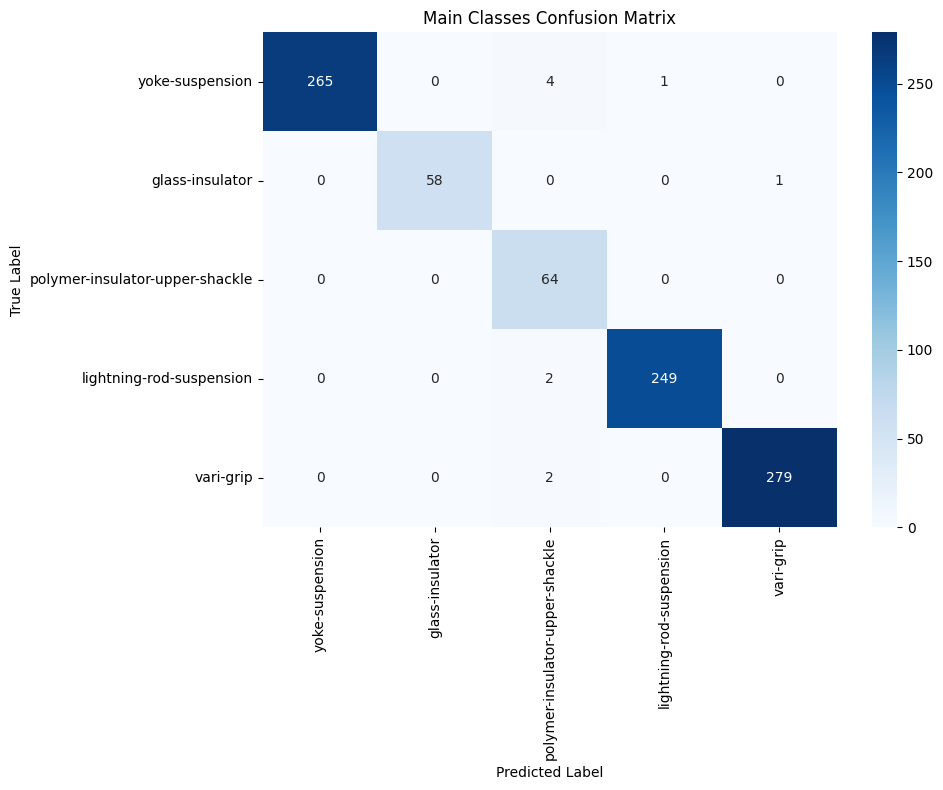

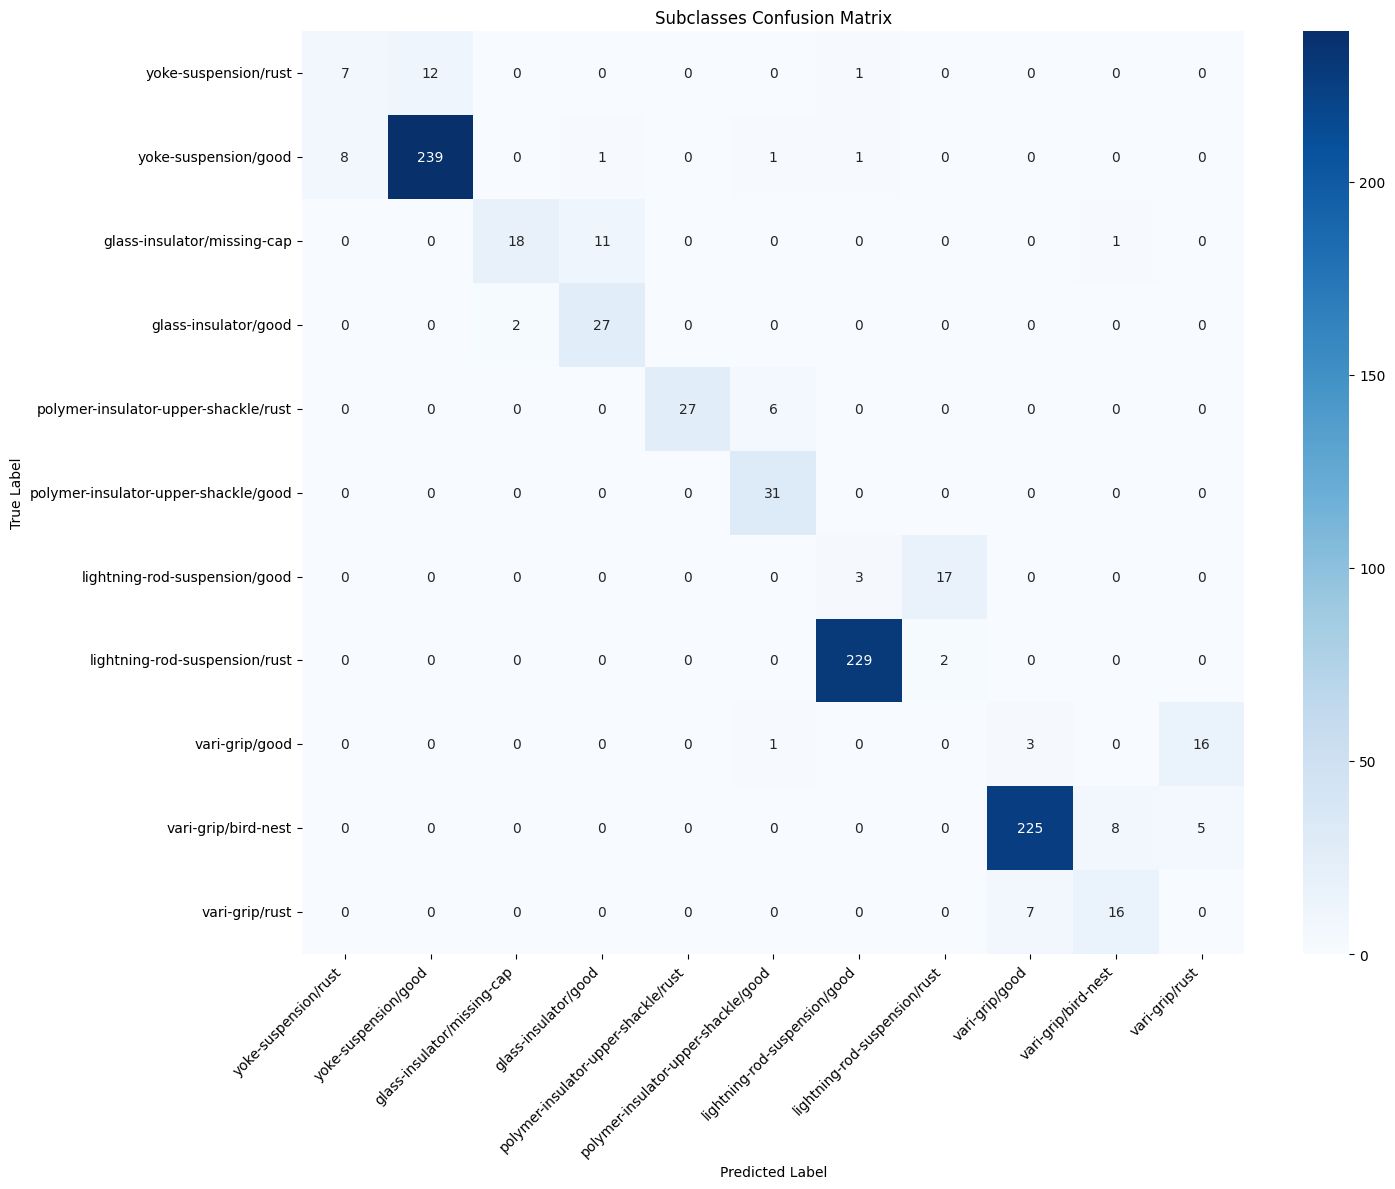


Performance Summary:
Main Classification Accuracy: 98.92%
Subclass Classification Accuracy: 39.46%

Subclass Performance by Main Class:

yoke-suspension:
Overall Accuracy: 92.48%
Individual Subclasses:
  - rust: 35.00%
  - good: 95.60%

glass-insulator:
Overall Accuracy: 77.59%
Individual Subclasses:
  - missing-cap: 60.00%
  - good: 93.10%

polymer-insulator-upper-shackle:
Overall Accuracy: 90.62%
Individual Subclasses:
  - rust: 81.82%
  - good: 100.00%

lightning-rod-suspension:
Overall Accuracy: 1.99%
Individual Subclasses:
  - good: 15.00%
  - rust: 0.87%

vari-grip:
Overall Accuracy: 3.93%
Individual Subclasses:
  - good: 15.00%
  - bird-nest: 3.36%
  - rust: 0.00%

Final Performance Summary:
Main Classification Accuracy: 98.92%
Subclass Classification Accuracy: 39.46%


In [153]:
final_main_metrics = classifier.evaluate_model(val_loader, mode='main')
final_sub_metrics = classifier.evaluate_model(val_loader, mode='sub')
plot_final_matrices(classifier, final_main_metrics, final_sub_metrics)
print("\nFinal Performance Summary:")
print(f"Main Classification Accuracy: {final_main_metrics['accuracy']:.2f}%")
print(f"Subclass Classification Accuracy: {final_sub_metrics['accuracy']:.2f}%")